# Investigating factors related to quality in Portuguese Wines

This dataset contains the results of 11 common physicochemical tests on a selection of 6,497 wines from Northwest Portugal. It was assembled with the goal of helping understand what factors impact quality in wine, something I'll also be looking into in this notebook.

URL: https://archive.ics.uci.edu/dataset/186/wine+quality

## Initial Exploration
Firstly let's retrieve the data and take a look at it.

In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

In [2]:
wine_quality_dataset = fetch_ucirepo(id=186) # This line may hang for a bit, it's a ~80mb data set

wine_quality_dataset.data.keys()


dict_keys(['ids', 'features', 'targets', 'original', 'headers'])

So we see that there are 5 parts to this data set.
- `ids` is a `None` value in this instance
- `features` is the physicochemical details minus the ratings
- `targets` is just the ratings on their own
- `original` is all of the data together
- `headers` is all of the header values for the `original` dataset

Now if we were training a model to predict quality then keeping our data separated into `features` and `targets` would be useful. But since we're just exploring we're going to focus on the whole dataset, as stored in `original`.

In [3]:
wine_quality: pd.DataFrame = wine_quality_dataset.data.original

wine_quality.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


As we see it contains a row id, 11 physicochemical test results, the rating, and the colour. For 14 columns total.

Let's take a look at some of those numbers now:

In [4]:
wine_quality.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


The first thing I notice is the counts, they all have the same count and it's the number we expect from the description of the dataset. This means no missing values. Secondly, I notice that the `color` header is gone-- as a categorical variable it's not included in `describe`.

Let's check how many of each color we have.

In [5]:
wine_quality.color.value_counts()

color
white    4898
red      1599
Name: count, dtype: int64

So we see that there are roughly three times as many whites as reds in this dataset, and that the sum is what we expect.

There are some other things that jump out from that description, but it's hard to really understand just from summary statistics. So let's try some visualisations. 

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

## Wine Quality Scores
Now that we have our graphing packages let's take a look at the quality metric.

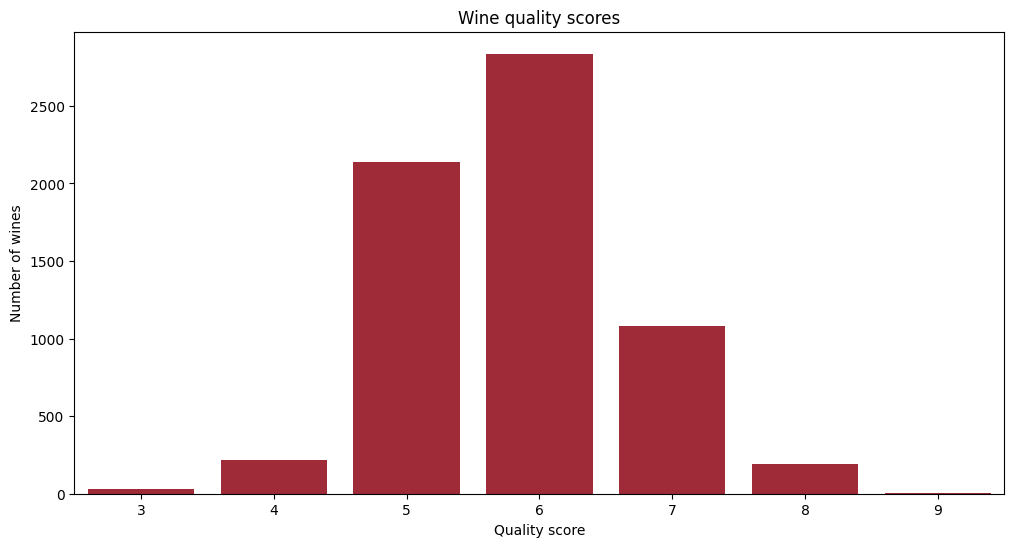

quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64

In [7]:
palette = {'red': '#b2182b', 'white': '#ececc9'}

quality_counts = wine_quality["quality"].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.countplot(data=wine_quality, x="quality", color=palette['red'])
plt.title("Wine quality scores")
plt.xlabel("Quality score")
plt.ylabel("Number of wines")
plt.show()

quality_counts


So despite being ostensibly a 1-10 scale, nothing gets above a 9 or below a 3. And the mean and median are both above the halfway point.

Let's take a look at which of the physicochemical features seems to correlate most with quality for the overall dataset before we narrow things down.

It's also worth noting that ~93% of all of our data falls into the 5, 6, and 7 buckets. That means the data in these buckets will go on to explain most of the correlation we see.

In [8]:
bulk_percent = round(((quality_counts[5] + quality_counts[6] + quality_counts[7])/quality_counts.sum())*100, 2)

f'{bulk_percent}%'

'93.17%'

## Correlations in the overall dataset

Let's look at the correlations with quality in the data set. Since quality is non-continuous we'll use Spearman correlation. https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient

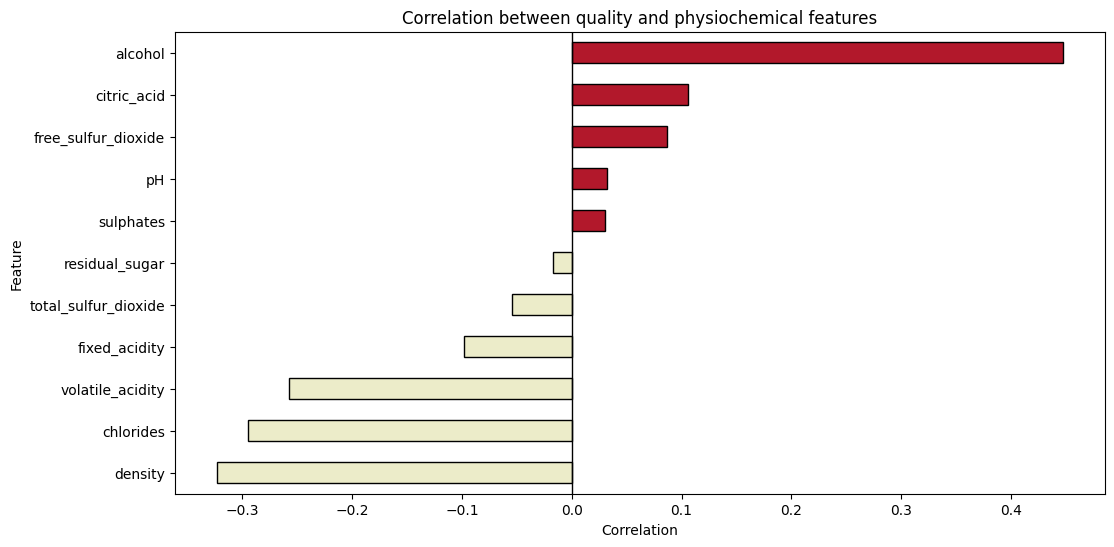

density                -0.322806
chlorides              -0.295054
volatile_acidity       -0.257806
fixed_acidity          -0.098154
total_sulfur_dioxide   -0.054777
residual_sugar         -0.016891
sulphates               0.029831
pH                      0.032538
free_sulfur_dioxide     0.086865
citric_acid             0.105711
alcohol                 0.446925
Name: quality, dtype: float64

In [9]:
def get_correlations(wines: pd.DataFrame, corr="quality", method="spearman")-> pd.Series: # We'll see later why we want this as a function
    return (wines.corr(
        numeric_only=True,
        method=method, # We default to spearman because quality is non-continuous
        )[corr]
    .drop(index=corr)
    .sort_values())

quality_correlations = get_correlations(wine_quality, corr="quality")

bar_colors = quality_correlations.apply(
    lambda value: palette['white'] if value < 0 else palette['red']
)

plt.figure(figsize=(12, 6))
quality_correlations.plot(
    kind="barh", color=bar_colors, edgecolor="black"
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Correlation between quality and physiochemical features")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()

quality_correlations


Alcohol, Density, Volatile Acidity, and Chlorides seem to have the most effect, but let's recall that this data contains both whites and reds-- each of which we might expect to be affected by these features differently. Let's try splitting them out and seeing what kind of difference we get.

## Comparing Red and White

In [10]:
red_wine_group, white_wine_group = wine_quality.groupby("color")

red_wines = red_wine_group[1] # TODO: Make sure this works consistantly
white_wines = white_wine_group[1]

del red_wine_group
del white_wine_group

red_wines.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [11]:
white_wines.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


So we see some differences already just by glancing at the data, sugar is higher in whites as we'd expect, but acidity is about the same which surprised me personally. Let's graph these to get a better idea of the differences.

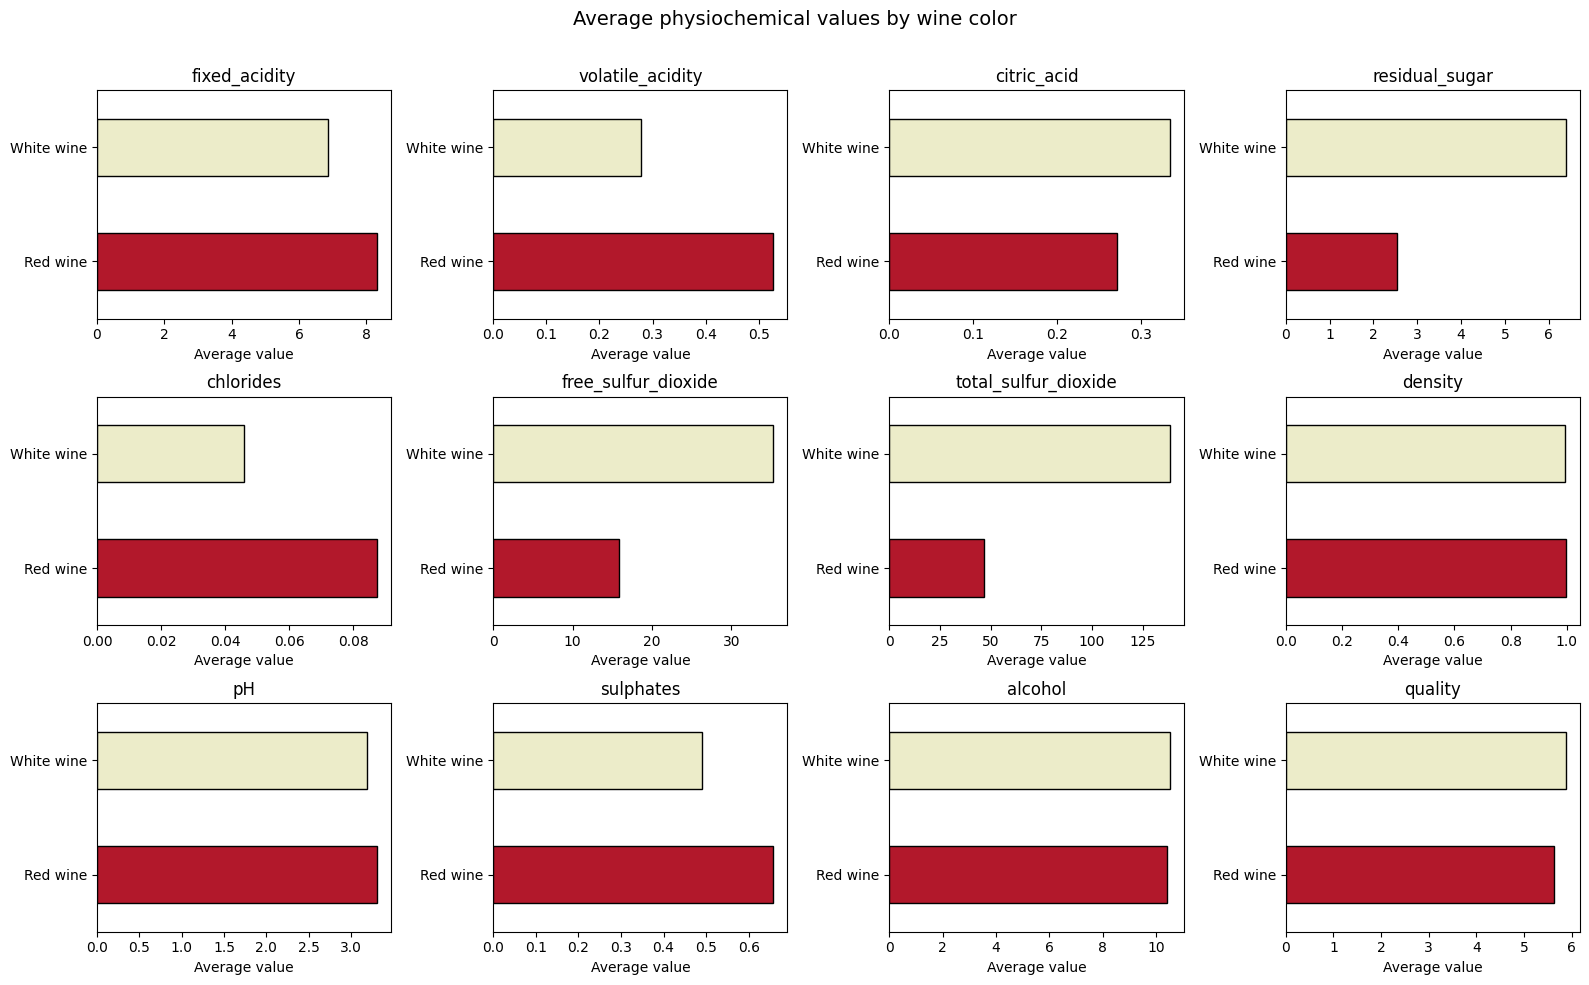

,Red wine,White wine
fixed_acidity,8.319637,6.854788
volatile_acidity,0.527821,0.278241
citric_acid,0.270976,0.334192
residual_sugar,2.538806,6.391415
chlorides,0.087467,0.045772
free_sulfur_dioxide,15.874922,35.308085
total_sulfur_dioxide,46.467792,138.360657
density,0.996747,0.994027
pH,3.311113,3.188267
sulphates,0.658149,0.489847


In [13]:
red_means = red_wines.mean(numeric_only=True)
white_means = white_wines.mean(numeric_only=True)

feature_means = pd.DataFrame({"Red wine": red_means, "White wine": white_means})

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axes = axes.flatten()

for ax, (feature, values) in zip(axes, feature_means.iterrows()):
    values.plot(kind="barh", ax=ax, color=[palette['red'], palette['white']], edgecolor="black")
    ax.set_title(feature)
    ax.set_xlabel("Average value")
    ax.set_ylabel("")
    ax.legend().set_visible(False)

for ax in axes[len(feature_means) :]:
    ax.remove()

fig.suptitle("Average physiochemical values by wine color", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

feature_means

So immediately we see that-- of our four key variables-- Alcohol and Density barely differ, but Volatile Acidity and Chlorides seem to be more associated with Reds than Whites. Given that those were negative correlations we might expect to see a lower average quality among the Reds, which we do, but only barely (~0.24). So instead let's see how correlation with quality differs between Reds and Whites.

In [14]:
red_corr = get_correlations(red_wines)
red_corr

volatile_acidity       -0.380647
total_sulfur_dioxide   -0.196735
chlorides              -0.189922
density                -0.177074
free_sulfur_dioxide    -0.056901
pH                     -0.043672
residual_sugar          0.032048
fixed_acidity           0.114084
citric_acid             0.213481
sulphates               0.377060
alcohol                 0.478532
Name: quality, dtype: float64

In [15]:
white_corr = get_correlations(white_wines)
white_corr

density                -0.348351
chlorides              -0.314488
total_sulfur_dioxide   -0.196680
volatile_acidity       -0.196562
fixed_acidity          -0.084485
residual_sugar         -0.082070
citric_acid             0.018333
free_sulfur_dioxide     0.023713
sulphates               0.033319
pH                      0.109362
alcohol                 0.440369
Name: quality, dtype: float64

We can already start to see the differences, but once again let's graph it.

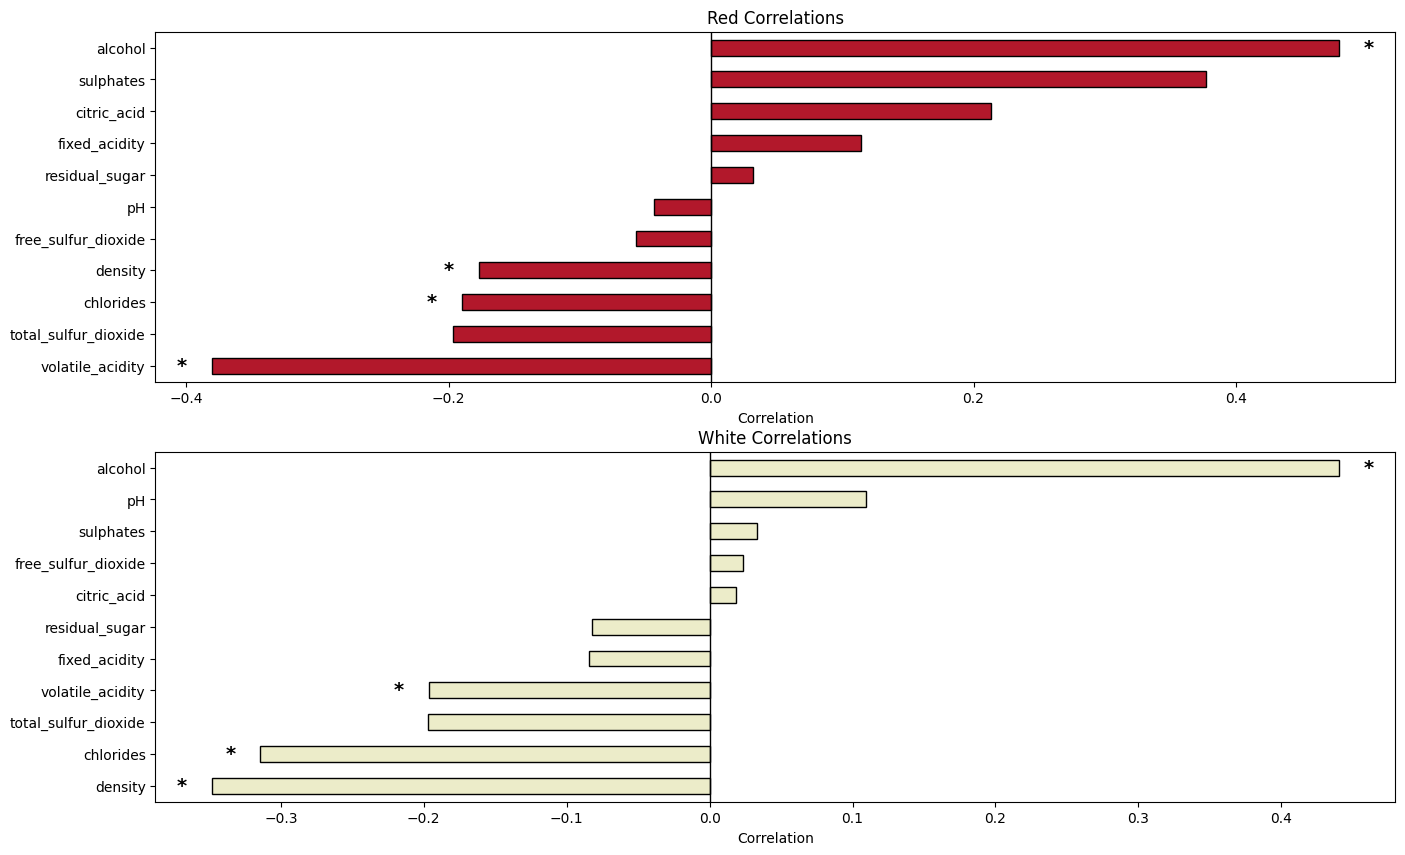

In [17]:
fig, [red_ax, white_ax] = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))


def mark_key_features(ax, correlations):
    highlight_features = {"alcohol", "density", "volatile_acidity", "chlorides"}
    x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
    offset = 0.02 * x_range
    for bar, feature in zip(ax.patches, correlations.index):
        if feature in highlight_features:
            x = bar.get_width()
            y = bar.get_y() + bar.get_height() / 2
            ax.text(
                x + (offset if x >= 0 else -offset),
                y,
                "*",
                va="center",
                ha="left" if x >= 0 else "right",
                fontsize=14,
                fontweight="bold",
                color="black",
            )

red_corr.plot(
    kind="barh",
    ax=red_ax,
    edgecolor="black",
    color=palette['red']

)
red_ax.set_title("Red Correlations")
red_ax.set_xlabel("Correlation")
red_ax.set_ylabel("")
red_ax.legend().set_visible(False)
red_ax.axvline(0, color="black", linewidth=1)
mark_key_features(red_ax, red_corr)

white_corr.plot(
    kind="barh",
    ax=white_ax,
    edgecolor="black",
    color=palette['white']
)
white_ax.set_title("White Correlations")
white_ax.set_xlabel("Correlation")
white_ax.set_ylabel("")
white_ax.legend().set_visible(False)
white_ax.axvline(0, color="black", linewidth=1)
mark_key_features(white_ax, white_corr)

plt.show()

I've marked the 4 values-- Alcohol, Density, Volatile Acidity, and Chlorides -- which had the clearest correlation on the overall data set with an asterisk.

While white looks quite similar to the overall, as might be expected due to having ~3.5 times the representation in the dataset, red has shifted significantly, with several new key correlates.

Before we turn to analysing each of these sub-datasets individually I'd like to look at the curious case of Total Sulfur Dioxide.

### Total Sulfur Dioxide

Total sulfur dioxide interestingly shows a very low correlation in the combined data set (~-0.055), but a moderately strong correlation in each individual data set (≈‑0.197 in each). I suspect this is an example of Simpson's Paradox. https://en.wikipedia.org/wiki/Simpson%27s_paradox

We see above that for both groups total sulfur dioxide has a negative correlation with quality, but _also_ that white wines are better represented at higher quality levels, and that they also have higher levels of sulfur dioxide. This means that while the trend is clear in each individual subgroup, when combined the lower levels and lower ranking of the reds bring the overall average down. See below for an illustration. 

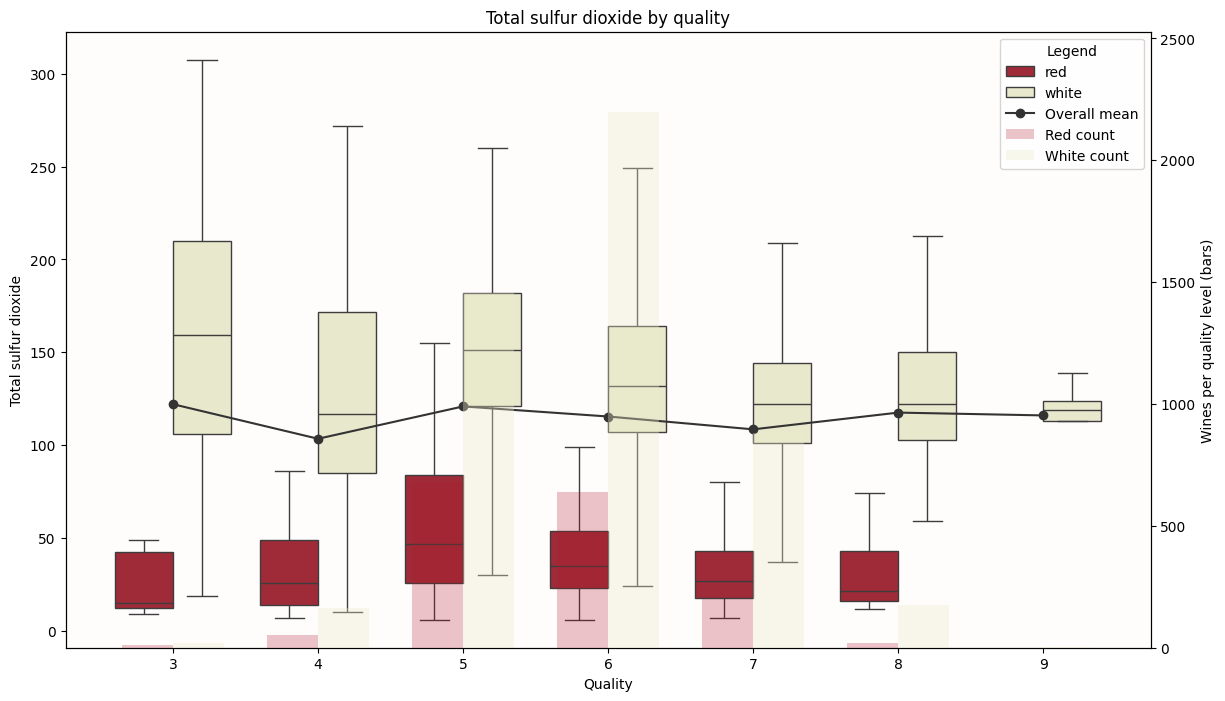

In [18]:
quality_order = sorted(wine_quality['quality'].unique())
unique_colors = ['red', 'white']
wine_by_quality_counts = (
    wine_quality.groupby(['quality', 'color'])
    .size()
    .reindex(
        pd.MultiIndex.from_product(
            [quality_order, unique_colors], names=['quality', 'color']
        ),
        fill_value=0,
    )
    .unstack('color')
)
pooled_means = wine_quality.groupby('quality')['total_sulfur_dioxide'].mean().reindex(quality_order)

fig, ax = plt.subplots(figsize=(14, 8))
ax.set_facecolor("#fffcfc")

sns.boxplot(
    data=wine_quality,
    x='quality',
    y='total_sulfur_dioxide',
    hue='color',
    order=quality_order,
    palette=palette,
    showfliers=False,
    ax=ax,
)

x_positions = list(range(len(quality_order)))

ax.plot(
    x_positions,
    pooled_means.values,
    color='#333333',
    marker='o',
    linestyle='-',
    linewidth=1.5,
    markersize=6,
    label='Overall mean',
)

ax.set_xticks(x_positions)
ax.set_xticklabels(quality_order)
ax.set_title('Total sulfur dioxide by quality')
ax.set_xlabel('Quality')
ax.set_ylabel('Total sulfur dioxide')

ax2 = ax.twinx()
ax2.set_facecolor('none')
bar_width = 0.35
ax2.bar(
    [x - bar_width / 2 for x in x_positions],
    wine_by_quality_counts['red'],
    width=bar_width,
    color=palette['red'],
    alpha=0.25,
    label='Red count',
)
ax2.bar(
    [x + bar_width / 2 for x in x_positions],
    wine_by_quality_counts['white'],
    width=bar_width,
    color=palette['white'],
    alpha=0.35,
    label='White count',
)
ax2.set_ylabel('Wines per quality level (bars)')
ax2.set_ylim(0, wine_by_quality_counts.values.max() * 1.15)
ax2.grid(False)

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, title='Legend')

plt.show()


We see above that even though the correlation exists for both subgroups, when merged the overall correlation remains flat.

## Exploring the White wines

Let's focus on just the white wines, and what values are important here, as a reminder

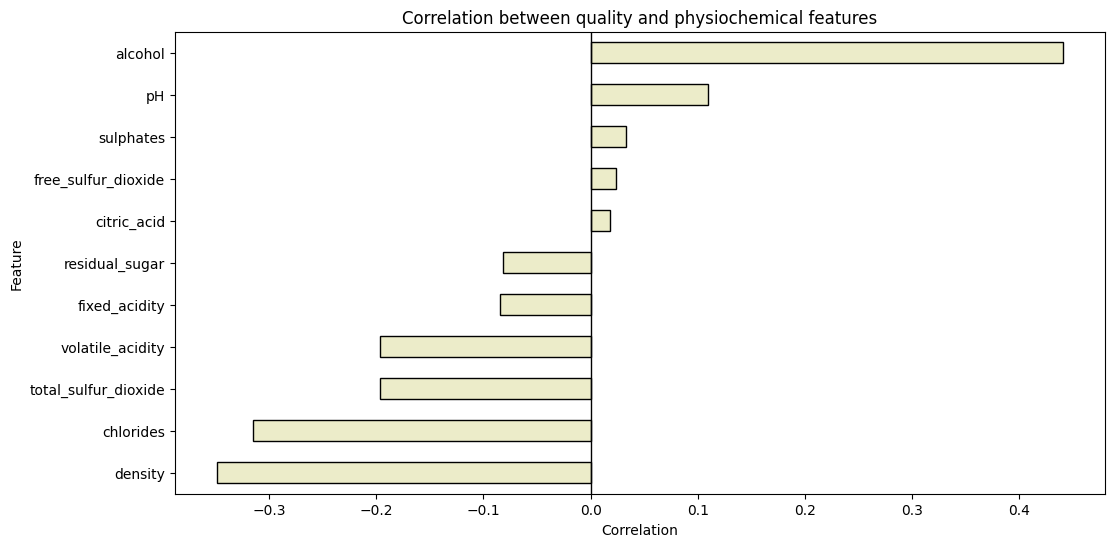

In [19]:
plt.figure(figsize=(12, 6))
white_corr.plot(
    kind="barh", color=palette['white'], edgecolor="black"
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Correlation between quality and physiochemical features")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()

And again, this time with absolute values to help us select which ones to focus on

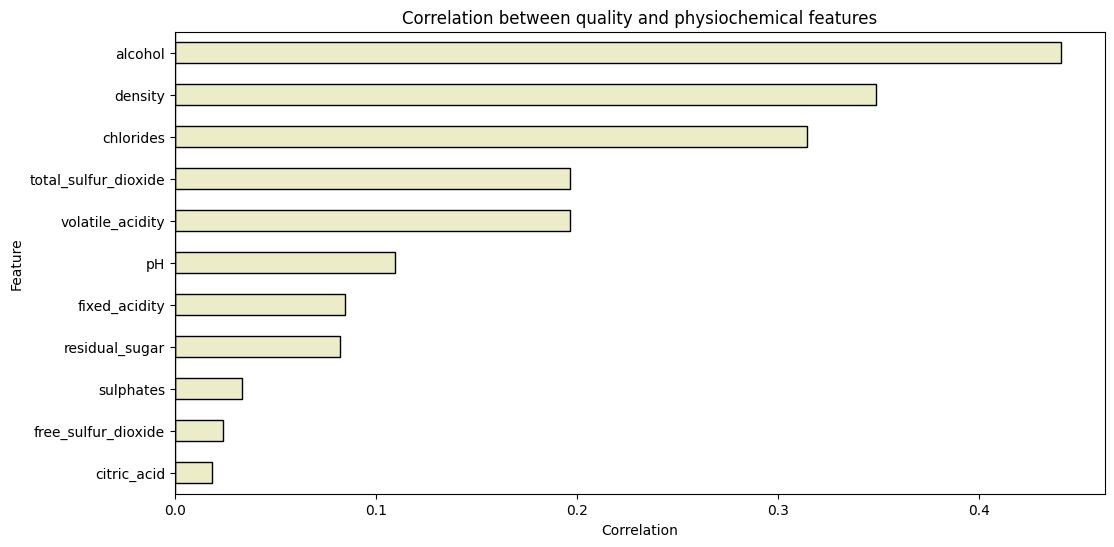

citric_acid             0.018333
free_sulfur_dioxide     0.023713
sulphates               0.033319
residual_sugar          0.082070
fixed_acidity           0.084485
pH                      0.109362
volatile_acidity        0.196562
total_sulfur_dioxide    0.196680
chlorides               0.314488
density                 0.348351
alcohol                 0.440369
Name: quality, dtype: float64

In [20]:
white_corr_abs = white_corr.apply(lambda value: abs(value)).sort_values()
plt.figure(figsize=(12, 6))
white_corr_abs.plot(
    kind="barh", color=palette['white'], edgecolor="black"
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Correlation between quality and physiochemical features")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()

# TODO: Add line at to 0.2 point

white_corr_abs

Let's set a cutoff point at 0.2 correlation and focus on just the values above that. So Alcohol, Density, and Chlorides.

### Alcohol

In [21]:
white_wines.alcohol.describe()

count    4898.000000
mean       10.514267
std         1.230621
min         8.000000
25%         9.500000
50%        10.400000
75%        11.400000
max        14.200000
Name: alcohol, dtype: float64

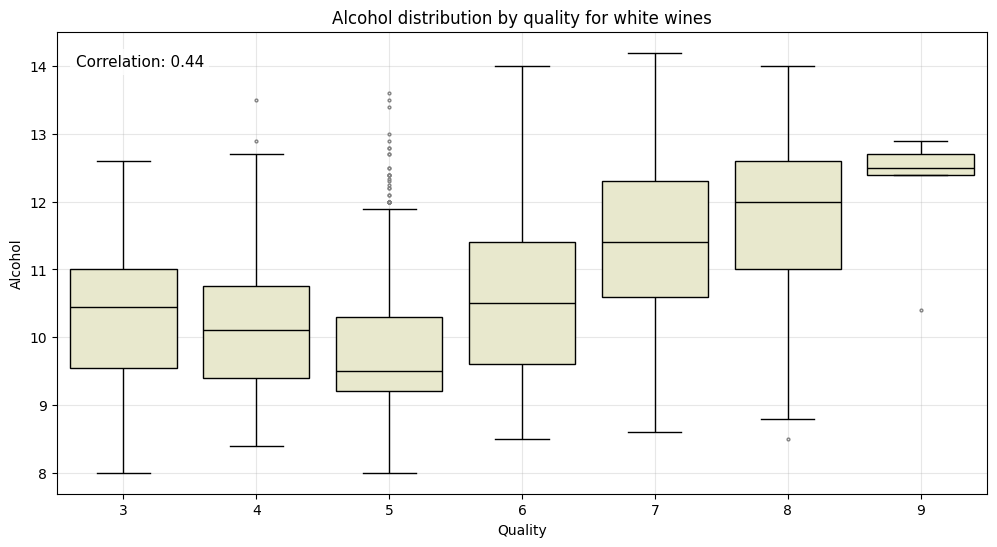

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=white_wines,
    x="quality",
    y="alcohol",
    color=palette["white"],
    boxprops={"edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    fliersize=2,
    ax=ax,
)
ax.set_title("Alcohol distribution by quality for white wines")
ax.set_xlabel("Quality")
ax.set_ylabel("Alcohol")
ax.grid(True, alpha=0.3)
corr = white_corr.alcohol
ax.text(
    0.02,
    0.95,
    f"Correlation: {corr:.2f}",
    transform=ax.transAxes,
    fontsize=11,
    ha="left",
    va="top",
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
)
plt.show()


The trend might not look overly clear from that, but it's a bit clearer when we remember that ~92% of all of the wines are in the 5, 6, and 7 buckets, and for those three buckets the trend is much clearer.

In [23]:
white_wine_quality_counts = wine_by_quality_counts.white
white_wine_quality_counts

quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: white, dtype: int64

In [24]:
percent = (white_wine_quality_counts[5] + white_wine_quality_counts[6] + white_wine_quality_counts[7])/white_wine_quality_counts.sum()*100
f'{percent:.2f}%'

'92.59%'

Let's move away from the association with quality and take a look at the alcohol data itself:

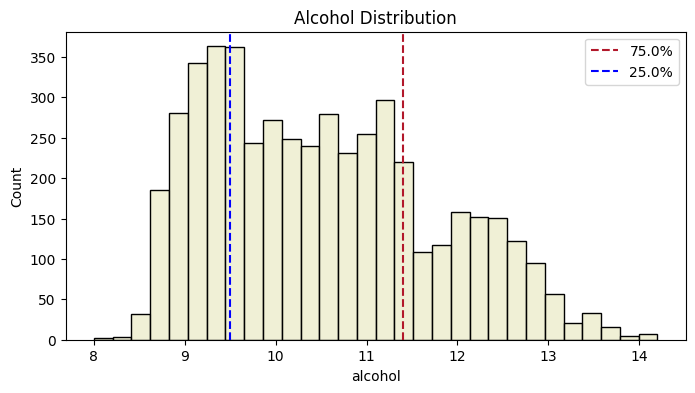

In [27]:
def plot_dist(feature, qs=[0.25, 0.75]):
    q1, q3 = white_wines[feature].quantile(qs)

    plt.figure(figsize=(8,4))
    sns.histplot(white_wines[feature], bins=30, color=palette['white'])
    plt.xlabel(f"{feature}")
    plt.title(f"{feature[0].upper()}{feature[1:]} Distribution")
    plt.axvline(q3, color=palette['red'], ls="--", label=f'{qs[1]*100}%')
    plt.axvline(q1, color='blue', ls="--", label=f'{qs[0]*100}%')
    plt.legend()
    plt.show()

plot_dist('alcohol')

So visually we can see that it doesn't fit any of our standard distributions especially well. The bulk of the items are in the lower end, with a slight tail out to the right. Something we can see in the skew statistic, in which anything over 0 indicates a positive tail. And the fact it extends further outside of the quartile range-- about 1.5 times the interquartile range to the right.

In [ ]:
white_wines.alcohol.skew()

Let's see what alcohol itself is most correlated with.

In [25]:
alcohol_correlations = get_correlations(white_wines, corr="alcohol", method="pearson") # switch to pearson as they're both continuous
alcohol_correlations

density                -0.780138
residual_sugar         -0.450631
total_sulfur_dioxide   -0.448892
chlorides              -0.360189
free_sulfur_dioxide    -0.250104
fixed_acidity          -0.120881
citric_acid            -0.075729
sulphates              -0.017433
volatile_acidity        0.067718
pH                      0.121432
quality                 0.435575
Name: alcohol, dtype: float64

Besides quality, whose correlation we've already explored, the highest correlates are:
- Density
- Chlorides
- Total Sulfur Dioxide
- Residual Sugar

The first three we'd expect, as they also correlate well with quality, but sugar is new. The correlation with quality was ~0.08 for whites, and even lower overall, while the correlation here is five times that. Though given that we use different algorithms to determine correlation in each instance, we can't compare the correlation with quality and alcohol precisely.

The negative correlation with alcohol does make sense however, as a higher alcohol level may imply that the yeast has consumed more of the sugar.

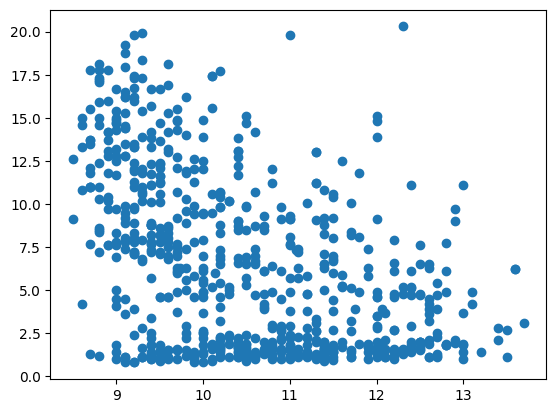

In [26]:
sample_size = 700 # sampling roughly 10% of the wines
sample_whites = white_wines.sample(sample_size, random_state=567) 
plt.scatter(sample_whites.alcohol, sample_whites.residual_sugar)
plt.show()


We see that trend in the scatter plot, broadly downwards with a much higher spread at lower levels. 

Let's try looking at plots of the remaining physicochemical measures:

Text(0.5, 1.0, 'Sulphates')

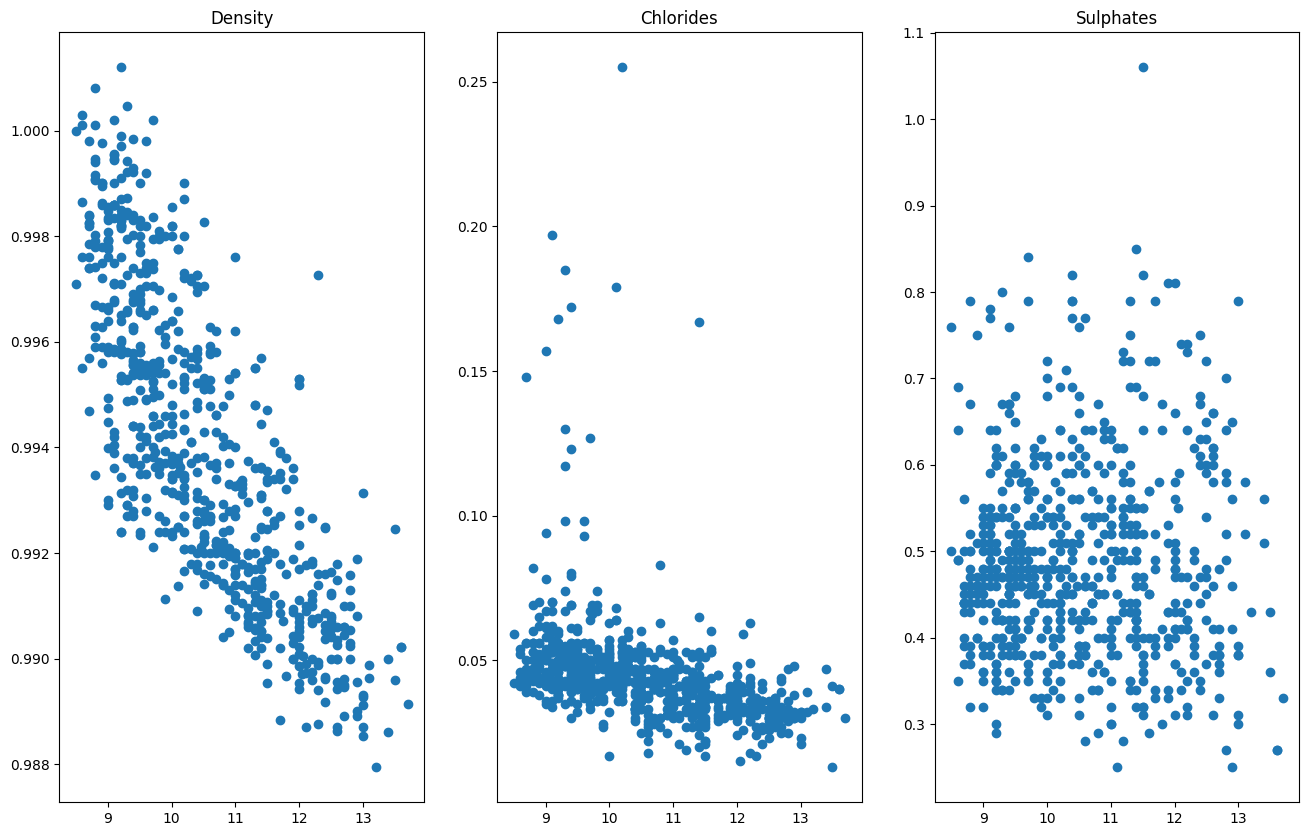

In [28]:
fig, [density, chlorides, sulfur] = plt.subplots(nrows=1, ncols=3, figsize=(16, 10)) 

density.scatter(sample_whites.alcohol, sample_whites.density)
density.set_title("Density")
chlorides.scatter(sample_whites.alcohol, sample_whites.chlorides)
chlorides.set_title("Chlorides")
sulfur.scatter(sample_whites.alcohol, sample_whites.sulphates)
sulfur.set_title("Sulphates")


Density looks pretty much like we'd expect it to, but Chlorides seems a bit odd, with what seems like several outliers. Let's look at that next

### Chlorides

In [29]:
white_wines.chlorides.describe()

count    4898.000000
mean        0.045772
std         0.021848
min         0.009000
25%         0.036000
50%         0.043000
75%         0.050000
max         0.346000
Name: chlorides, dtype: float64

The max is a little high relative to those other numbers, but we won't learn more until we graph it.

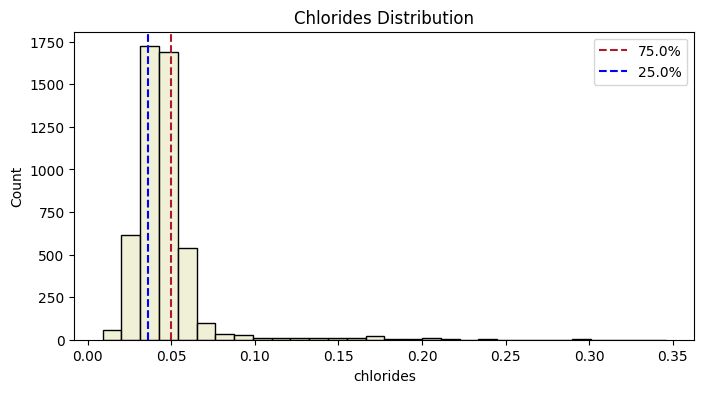

In [30]:
plot_dist('chlorides')

In [31]:
white_wines.chlorides.skew()

np.float64(5.023330682759711)

This is a very skewed distribution, as we can see from the shape and the skew characteristic. Let's try plotting it again with the lines at the 0.05 and 0.95 levels to see just how extreme this is.

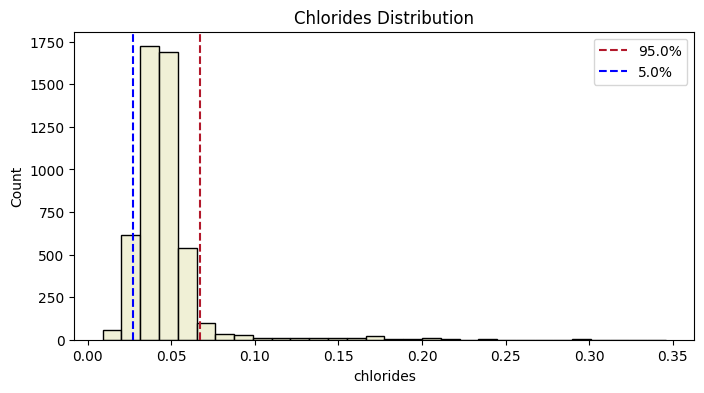

In [32]:
plot_dist('chlorides', qs=[0.05, 0.95])

As you can see, there's a significant long tail past the 95% mark.

Let's try trimming some of those outliers and see how that affects the correlation with alcohol and quality. We're going to use a heuristic based off of the interquartile range. The interquartile range uses the elements that mark the 25%, 50%, and 75% points in a given series; the 50% mark is the median, and the IQR is the difference between the 25% and the 75%. It lets you get an idea of the bulk of the data, without including the extremes.


For our example, anything more than 1.5 times the IQR that falls _outside_ of the IQR is marked as an outlier and removed. So if the 25% mark was 10 and the 75% mark was 15 our IQR would be 5, since `1.5*5 = 7.5`, we define an outlier as anything greater than `15 + 7.5 = 22.5` or less than `10 - 7.5 = 2.5`.

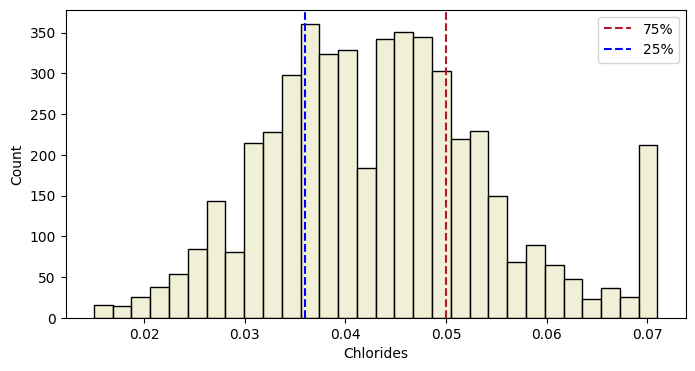

In [33]:
q1, q3 = white_wines.chlorides.quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
trimmed_chlorides = white_wines.chlorides.clip(lower=lower, upper=upper)


plt.figure(figsize=(8,4))
sns.histplot(trimmed_chlorides, bins=30, color=palette['white'])
plt.xlabel(f"Chlorides")
plt.axvline(q3, color=palette['red'], ls="--", label=f'{75}%')
plt.axvline(q1, color='blue', ls="--", label=f'{25}%')
plt.legend()
plt.show()

That's the new distribution, a lot more symmetrical and it almost looks like a normal distribution. I'd have preferred that spike at 7 also get dropped, but I'd rather stick with my heuristic than edit data at will.

Let's try rechecking the correlations.

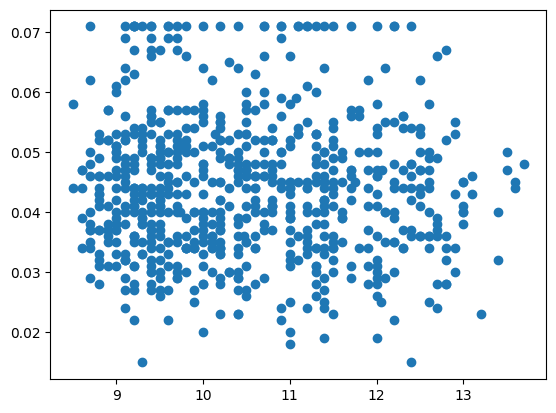

In [34]:
plt.scatter(sample_whites.alcohol, trimmed_chlorides.sample(sample_size))
plt.show()

In [41]:
from scipy import stats

al_chl_corr, _ = stats.pearsonr(white_wines.alcohol, trimmed_chlorides)

al_chl_corr

np.float64(-0.5409701493758224)

We see that having removed the outliers the correlation has grown a lot stronger. Though unlike on the scatterplot above which included the outliers, this one makes it much harder to see the direction of correlation.

In [ ]:
qual_chl_corr, _ = stats.spearmanr(white_wines.quality, trimmed_chlorides)
qual_chl_corr

np.float64(-0.3145377804569984)

In [52]:
white_corr.chlorides

np.float64(-0.31448847828244203)

We do not see any meaningful change with the quality correlation however for two reasons, firstly because spearman is largely concerned with rank, which barely moves when we clip outliers, and it moves even less than it otherwise would because our data is so compressed onto a few of the avalible ranks.

## Conclusion

In conclusion there are a lot of factors that go into making a good wine, including Density, Chlorides, and Total Sulfur Dioxide. But since none of those are printed on the label, your best bet is to grab whichever one is strongest.